In [23]:
from IPython.core.display import display, HTML
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cv2
from collections import Counter
import pg_fitter_tools as fit
import sk_geo_tools as sk
import os
import csv
import math
from IPython.display import Image
import plotly.graph_objects as go
#import plotly.plotly as py
#%matplotlib notebook

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html
from scipy.spatial.transform import Rotation as R

## Constants

In [24]:
WIDTH = 4000
HEIGHT = 2750
####################Internal Camera Parameters########################################
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [-0.2398, 0.1145]
tangential_distortion = [0, 0]
######################################################################################

## Functions

In [25]:
# Plot points
def plot_pmts(coordinates, imageIdentifier, off_set=0, color=(0,0,230)):
    counter = 0
    for i in coordinates:
        if np.abs(int(i[0]))<=4000 and np.abs(int(i[1])-int(off_set))<=2750:
            plotx = int(i[0])
            ploty = int(i[1])-int(off_set)
            cv2.circle(imageIdentifier,(plotx,ploty),9,color,-1)
            counter=counter+1

# Obtain Reprojected Points
def obtain_reprojected_points(features, rotation_vector, translation_vector):
    nfeatures = len(features)

    seed_feature_locations = np.zeros((nfeatures, 3))
    feature_index = {}
    index_feature = {}
    f_index = 0
    for f_key, f in features.items():
        feature_index[f_key] = f_index
        index_feature[f_index] = f_key
        seed_feature_locations[f_index] = f
        f_index += 1

    
    rotation_matrix = cv2.Rodrigues(rotation_vector)[0]
    transformed_positions = (rotation_matrix @ seed_feature_locations.T).T + translation_vector.T
    indices = np.where(transformed_positions[:,2]>0)[0] #filtering out points behind the camera.
    
    print("seed size = ", np.shape(seed_feature_locations))
    print("transformed_position size = ", np.shape(transformed_positions))
    
    print("translation size = ", np.shape(translation_vector))
    camera_matrix = build_camera_matrix(focal_length, principle_point)
    distortion = build_distortion_array(radial_distortion, tangential_distortion)
    reprojected = cv2.projectPoints(seed_feature_locations[indices], rotation_vector, translation_vector,camera_matrix, distortion)[0].reshape((indices.size, 2))
   
    reprojected_points = {}
    reprojected_points = dict(zip([index_feature[ii] for ii in indices], reprojected))


    for point in list(reprojected_points):
        if(reprojected_points[point][0]>WIDTH or reprojected_points[point][0]<0 or reprojected_points[point][1]>HEIGHT or reprojected_points[point][1]<0):
            reprojected_points.pop(point)


    return reprojected_points

def build_camera_matrix(focal_length, principle_point):
    return np.array([
        [focal_length[0], 0, principle_point[0]],
        [0, focal_length[1], principle_point[1]],
        [0, 0, 1]], dtype=float)


def build_distortion_array(radial_distortion, tangential_distortion):
    return np.concatenate((radial_distortion, tangential_distortion)).reshape((4, 1))


def plotter(points, color, marker, label):
    plotLegend = False
    for i in points:
        #print(i[0],i[1],i[2])
        if(plotLegend == False):
            ax.plot([float(i[0])],[float(i[1])],[float(i[2])],color = color, marker = marker, label=label)
            plotLegend = True
        else:
            ax.plot([float(i[0])],[float(i[1])],[float(i[2])],color = color, marker = marker)
    
def plotter_labels(points):
    for i in points:
        ax.text(float(i[0]),float(i[1]),float(i[2])+10, i[3][-3:],size=12, zorder=4, color='#5158fc')
        
        
def get_world_points(image):
    world_points = []
    for pmt in pmt_reprojected_points[image]:
        if pmt in all_pmts:
            world_points.append((all_pmts[pmt][0],all_pmts[pmt][1],all_pmts[pmt][2]))
    return np.array(world_points)

def plot(data, op, s,c, n):
    return go.Scatter3d(
    x=data[:,0], 
    y=data[:,1], 
    z=data[:,2], 
    marker=go.scatter3d.Marker(size=s,color = c), 
    #marker=dict(
    #        color=c,
    #        size=3,
    #    ), 
    opacity=op, 
    mode='markers',
    name = n)


def obtain_rotation_translation(z,y,x, camera_positions):
    print(z,y,x)
    r_z = np.array([[
                    [np.cos(z), -np.sin(z), 0.],
                    [np.sin(z), np.cos(z), 0.],
                    [0.,0.,1]
                    ]])

    r_y = np.array([[
                    [np.cos(y), 0, np.sin(y)],
                    [0, 1, 0.],
                    [-np.sin(y),0.,np.cos(y)]
                    ]])

    r_x = np.array([[
                    [1, 0, 0],
                    [0, np.cos(x), -np.sin(x)],
                    [0, np.sin(x), np.cos(x)]
                    ]])

    camera_orientations = np.matmul(r_z,np.matmul(r_y,r_x))
    #camera_orientations = np.matmul(r_x,np.matmul(r_y,r_z))
    #camera_orientations = np.matmul(r_y,np.matmul(r_z,r_x))
    #camera_orientations = np.matmul(r_y,np.matmul(r_x,r_z))
    #camera_orientations = np.matmul(r_x,np.matmul(r_z,r_y))
    #camera_orientations = np.matmul(r_z,np.matmul(r_y,r_x))
    #camera_orientations = np.matmul(r_z,np.matmul(r_x,r_y))
    print("camera orientations are:", "\n", camera_orientations)
    camera_rotations = -np.array([cv2.Rodrigues(camera_orientations[0])[0]])
    camera_translations = -np.matmul(np.linalg.inv(camera_orientations), camera_positions)

    rotation_vector = np.array([camera_rotations[0][0],camera_rotations[0][1], camera_rotations[0][2]])
    translation_vector = np.array([[camera_translations[0][0]],[camera_translations[0][1]],[camera_translations[0][2]]])
    
    return rotation_vector, translation_vector


def obtain_rotation_translation_V2(z,y,x, camera_positions):
    r_new = R.from_euler('zyx', [z,y,x])
    camera_orientations = r_new.as_matrix()

    print("camera orientations are:", "\n", camera_orientations)
    camera_rotations = -np.array([cv2.Rodrigues(camera_orientations)[0]])
    camera_translations = -np.matmul(np.linalg.inv(camera_orientations), camera_positions)
    #print("--",camera_translations)
    rot = r_new.as_rotvec()
    rotation_vector = np.array([[rot[0]],[rot[1]], [rot[2]]])
    translation_vector = np.array([[camera_translations[0]],[camera_translations[1]],[camera_translations[2]]])
    print("--",r_new.as_rotvec())
    return rotation_vector, translation_vector


## 045
##### Drone data
```
depth = 15.17
yaw = 64
pitch = 2
roll = -1
```
(Depth in m, angles in degrees)
##### Deduced external camera parameters
```
rotation_vector = np.array([[1.52593994],[-0.71901074],[0.60290209]])
translation_vector = np.array([[-100.74973094],[1606.91543897],[-916.79105257]])
```

## 046

##### Drone data
```
depth = 15.17
yaw = 59
pitch = 2
roll = -1
```
(Depth in m, angles in degrees)
##### Deduced external camera parameters
```
rotation_vector = np.array([[1.51866624],[-0.76826861],[0.64427387]])
translation_vector = np.array([[-185.15488902],[1626.26076905],[-921.54663445]])
```

In [26]:
image_names = ["045","046"]
#rotation_vectors = {
#    "045":np.array([[1.52593994],[-0.71901074],[0.60290209]]),
#    "046":np.array([[1.51866624],[-0.76826861],[0.64427387]]),
#    "046-new":np.array([[0.0],[0.0],[0.0]])
#}

#translation_vectors = {
#    "045":np.array([[-100.74973094],[1606.91543897],[-916.79105257]]),
#    "046":np.array([[-185.15488902],[1626.26076905],[-921.54663445]]),
#    "046-new":np.array([[0.0],[0.0],[0.0]])
#}

rotation_vectors = {
    "045":np.array([[ 1.49286548],[-0.67181681],[0.61404137]]),
    "046":np.array([[ 1.46884462],[-0.73619339],[0.67964682]]),
    "046-new":np.array([[0.0],[0.0],[0.0]])
}

translation_vectors = {
    "045":np.array([[-161.14340624],[1522.59325055],[-991.13768429]]),
    "046":np.array([[ -197.7744796],[1528.37013497],[-1002.67418826]]),
    "046-new":np.array([[0.0],[0.0],[0.0]])
}


yaws = {
    "045":64.0,
    "046":59.0,
    "046-new":0.0
}



In [27]:
# Read all 3D PMT locations
all_pmts = fit.read_3d_feature_locations("parameters/SK_all_PMT_locations.txt")

all_bolts = sk.get_bolt_locations_barrel(all_pmts)

all_pmt_coords = np.stack(list(all_pmts.values()))

In [28]:
# Obtain 2D reprojected feature points
pmt_reprojected_points = {
    "045":obtain_reprojected_points(all_pmts, rotation_vectors["045"], translation_vectors["045"]),
    "046":obtain_reprojected_points(all_pmts, rotation_vectors["046"], translation_vectors["046"])#,
}

pmt_repro_coords = {
    "045":np.stack(list(pmt_reprojected_points["045"].values())),
    "046":np.stack(list(pmt_reprojected_points["046"].values()))#,
}

pmt_world_points = {
    "045":get_world_points("045"),
    "046":get_world_points("046")#,
}

seed size =  (11146, 3)
transformed_position size =  (11146, 3)
translation size =  (3, 1)
seed size =  (11146, 3)
transformed_position size =  (11146, 3)
translation size =  (3, 1)


In [29]:
# Find camera poses:
camera_orientations = {} 
camera_positions = {}
camera_translations = {}
camera_rotations = {}
for i in image_names:
    rotations = np.zeros((1, 3))
    translations = np.zeros((1, 3))
    rotations[0, :] = rotation_vectors[i].ravel()
    translations[0, :] = translation_vectors[i].ravel()
    #print(translations)
    orientations, positions = fit.camera_world_poses(rotations, translations)
    camera_orientations[i] = orientations
    camera_positions[i] = positions
    camera_translations[i] = translations
    camera_rotations[i] = rotations
    

## Calculating position in image 046
yaw_045 = 64
yaw_046 = 59
delta_yaw = 5

These need to be converted to match coordinate system where the angle is measured CC from the x axis.
Need to find conversion angle.

045: x = 888.3573, y = 572.0607, yaw = **32.7796**

046: x = 987.671, y = 468.3108, yaw = **25.3683**

delta_yaw = **7.4**, does not match sensor data.


25.3683 = 59 - k

32.7796 = 64 - k

31.2204 < k < 33.6317

So take **k = 32**



In [30]:
yaw_conversion = 32

delta_yaw = yaws["046"] -yaws["045"]  # = 5

yaw_46 = np.degrees(np.arctan(camera_positions["045"][1]/camera_positions["045"][0])) + delta_yaw
print(np.degrees(np.arctan(camera_positions["046"][1]/camera_positions["046"][0])))
z = np.radians(yaw_46)
#yaw_conversion = 130 - 18.64869125
#yawvar = yaws["045"] - delta_yaw # = 64-5 = 59
#yawvar = -yawvar + yaw_conversion + 360.*(yaw_conversion<yawvar) # = 52


# For x and y (pitch and roll) angles, 

# take orientation from 045 
#y = np.arctan(-camera_orientations["045"][0][2][0] / (np.sqrt((camera_orientations["045"][0][2][1])**2 + (
#    camera_orientations["045"][0][2][2])**2))) + np.pi
#x = np.arctan(camera_orientations["045"][0][2][1]/camera_orientations["045"][0][2][2])

# or make perpendicular to wall assumption
y = 0# np.radians(180) #180
x = np.radians(90) #90

theta = np.radians(yaws["046"]-35.18)
#print(yawvar)


# Camera position
# calculate the radius of the camera position from the centre of the detector.
#RADIUS = np.sqrt(camera_positions["046"][0]**2 + camera_positions["046"][1]**2)
RADIUS = np.sqrt(camera_positions["045"][0]**2 + camera_positions["045"][1]**2)
cam46X = RADIUS * np.cos(z)
cam46Y = RADIUS * np.sin(z) 
cam46Z = camera_positions["045"][2]

camera_positions["046-new"] = np.array([cam46X, cam46Y, cam46Z])
#camera_positions["046-new"]=camera_positions["046"]


#Y-axis of camera frame is opposite of Yaw axis of drone.
#X-axis of drone is opposite of Pitch axis of drone.
#Z-axis of drone is same as roll axis of drone.
yaw0=-(64*math.acos(-1)/180.0) #if the drone rotates theta along yaw axis, it rotates -theta along Y-axis of camera.
pitch0=-(2*math.acos(-1)/180.0) #if the drone rotates theta along pitch axis, it rotates -theta along X-axis of camera.
roll0=-1*math.acos(-1)/180.0 #if the drone rotates theta along roll axis, it also rotates theta along Z-axis of camera.

yaw1=-(59*math.acos(-1)/180.0) #if the drone rotates theta along yaw axis, it rotates -theta along Y-axis of camera.
pitch1=-(2*math.acos(-1)/180.0) #if the drone rotates theta along pitch axis, it rotates -theta along X-axis of camera.
roll1=-1*math.acos(-1)/180.0 #if the drone rotates theta along roll axis, it also rotates theta along Z-axis of camera.

#This is rotation matrix from initial condition to 045 frame.
#given a vector in frame rotated about pitch axis, this matrix finds coordinate of a vector in unrotated frame.
ABp = np.array([[1.0,           0.0,           0.0],
                [0.0,math.cos(pitch0),-math.sin(pitch0)],
                [0.0,math.sin(pitch0),math.cos(pitch0)]])

#given a vector in frame rotated about yaw axis, this matrix finds coordinate of a vector in unrotated frame.
ABy = np.array([[math.cos(yaw0),0.0,math.sin(yaw0)],
                [0.0,           1.0,           0.0],
                [-math.sin(yaw0),0.0, math.cos(yaw0)]])

#given a vector in frame rotated about roll axis, this matrix finds coordinate of a vector in unrotated frame.
ABr = np.array([[math.cos(roll0),-math.sin(roll0),0],
                [math.sin(roll0),math.cos(roll0),0.0],
                [0.0,           0.0,           1.0]])

#This is rotation matrix from initial condition to 046 frame.
ACp = np.array([[1.0,           0.0,           0.0],
                [0.0,math.cos(pitch1),-math.sin(pitch1)],
                [0.0,math.sin(pitch1),math.cos(pitch1)]])

ACy = np.array([[math.cos(yaw1),0.0,math.sin(yaw1)],
                [0.0,           1.0,           0.0],
                [-math.sin(yaw1),0.0, math.cos(yaw1)]])


ACr = np.array([[math.cos(roll1),-math.sin(roll1),0],
                [math.sin(roll1),math.cos(roll1),0.0],
                [0.0,           0.0,            1.0]])


#Given coordinate in frame A, find the matrix that will give the coordinate in frame B
#If there is no transpose the matrix will: given a vector in rotated frame B, find coordinate of a vector in frame A.
#For rotation matrix inverse is transpose.
rot_vec_A_B = (ABr@ABp@ABy).transpose()
#Given coordinate in frame A, find the matrix that will give the coordinate in frame C
rot_vec_A_C = (ACr@ACp@ACy).transpose()
#Given coordinate in frame B, find the matrix that will give the coordinate in frame C
rot_vec_B_C = rot_vec_A_C@rot_vec_A_B.transpose()

#the rotation matrix for 045 finds: given a coordinate in world frame find a coordinate in camera 045 frame i.e,. frame B
#So this new matrix: given a coordinate in world frame finds a coordinate in frame of camera in 046 frame. i.e. frame C.
rot_vector_046 = rot_vec_B_C@cv2.Rodrigues(rotation_vectors["045"])[0]

rot_vector_obtained = cv2.Rodrigues(rotation_vectors["046"])[0]
print("calculated 046 rotation = ",rot_vector_046 )
print("obtained 046 rotation = ",rot_vector_obtained )

rotation_vectors["046-new"] = cv2.Rodrigues(rot_vector_046)[0]

camp = np.squeeze(camera_positions["046-new"])
print("camp size = ", np.shape(camp))
tv = -cv2.Rodrigues(rotation_vectors["046-new"])[0]@camp.transpose()

print("calculated 046 translation = ",tv )
print("obtained 046 translation = ",translation_vectors["046"] )
print("tv size = ", np.shape(tv))
#tv = -(cv2.Rodrigues(rotation_vectors["046-new"])[0]@((cv2.Rodrigues(rotation_vectors["045"])[0]@(camera_positions["046-new"].transpose()))+np.squeeze(camera_translations["045"]).transpose())).transpose()
#tv = -(cv2.Rodrigues(rotation_vectors["046-new"][0])@camp.transpose()
translation_vectors["046-new"] = np.array([[tv[0]],[tv[1]],[tv[2]]])#translation_vectors["046"]#
#rotation_vectors["046-new"], translation_vectors["046-new"] = obtain_rotation_translation_V2(z,y,x,camera_positions["046-new"])

print("calculated 046 translation = ",translation_vectors["046-new"] )
print("obtained 046 translation = ",translation_vectors["046"] )
pmt_reprojected_points["046-new"] = obtain_reprojected_points(all_pmts, rotation_vectors["046-new"], translation_vectors["046-new"])
pmt_repro_coords["046-new"] = np.stack(list(pmt_reprojected_points["046-new"].values()))
pmt_world_points["046-new"] = get_world_points("046-new")

print("Actual camera orientations are: \n", camera_orientations["046"])
print("\nRadius is", RADIUS)
print("Height is", cam46Z)
print("Camera angles are", x,y,z,"\n")
print("Camera positions are", cam46X,cam46Y,cam46Z)
print("Actual camera position is", camera_positions["046"], "\n")
print("camera translations are","\n",translation_vectors["046-new"])
print("Actual camera translations are", "\n",translation_vectors["046"], "\n")
print("camera roations are", "\n",rotation_vectors["046-new"])
print("Actual camera roations are", "\n",rotation_vectors["046"])


25.50900005300756
calculated 046 rotation =  [[ 0.61483329 -0.78833619 -0.02249597]
 [-0.04037921 -0.00297964 -0.99917998]
 [ 0.78762272  0.61523749 -0.03366438]]
obtained 046 rotation =  [[ 6.17113101e-01 -7.86494807e-01 -2.44405129e-02]
 [-3.83601695e-02  9.53534423e-04 -9.99263523e-01]
 [ 7.85938877e-01  6.17596154e-01 -2.95816355e-02]]
camp size =  (3,)
calculated 046 translation =  [-165.41198722 1524.19510061 -987.96734915]
obtained 046 translation =  [[ -197.7744796 ]
 [ 1528.37013497]
 [-1002.67418826]]
tv size =  (3,)
calculated 046 translation =  [[-165.41198722]
 [1524.19510061]
 [-987.96734915]]
obtained 046 translation =  [[ -197.7744796 ]
 [ 1528.37013497]
 [-1002.67418826]]
seed size =  (11146, 3)
transformed_position size =  (11146, 3)
translation size =  (3, 1)
Actual camera orientations are: 
 [[[ 6.17113101e-01 -3.83601695e-02  7.85938877e-01]
  [-7.86494807e-01  9.53534423e-04  6.17596154e-01]
  [-2.44405129e-02 -9.99263523e-01 -2.95816355e-02]]]

Radius is 1057.600

## Visualizing with expected geometry in 3D and reprojecting onto image 046

r size =  (3, 3)
a size =  (3, 1)


Pmt repo names =  (125,)
Pmt repo coords =  (125, 2)


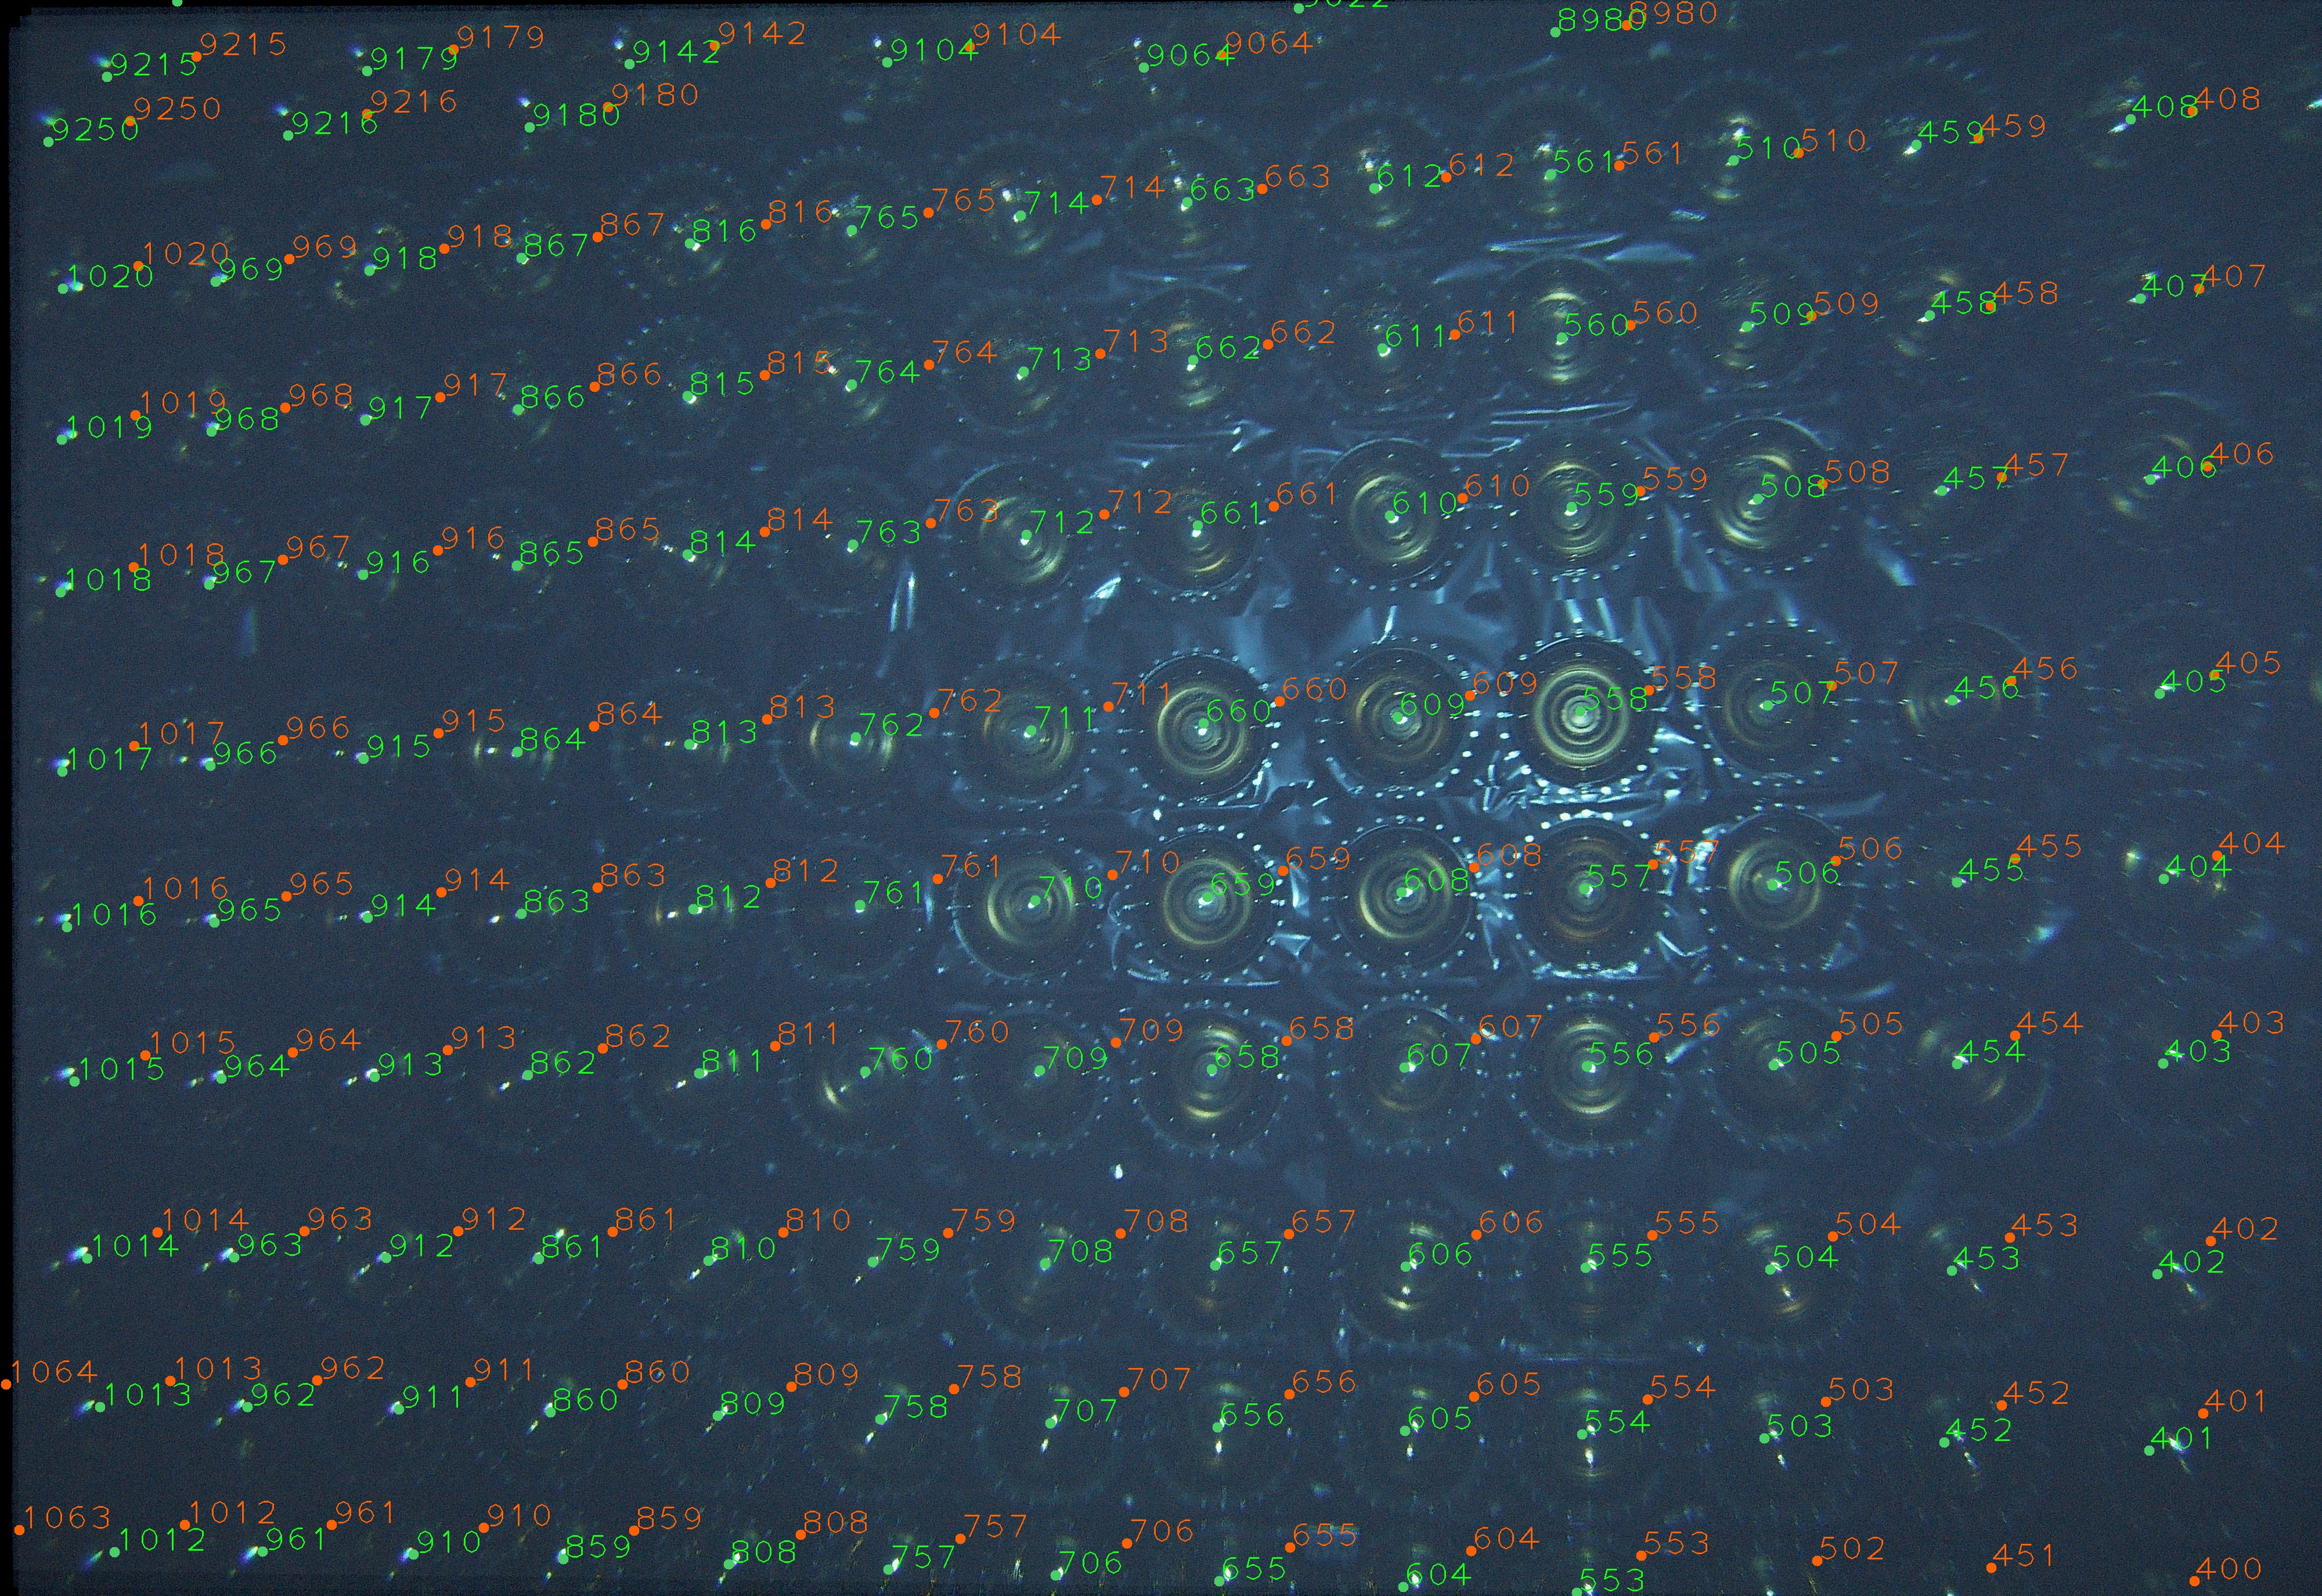

In [31]:
# Visualize
fig = go.Figure()


# 3D plot with 045 and 046 pose from manually labelled points, and calculated pose 046. 
colors = ["#0362fc","#2ca346", "#fc6203"]
color_count = 0
for image in pmt_world_points:
    image_pmts_fig = plot(pmt_world_points[image], 0.75, 3, colors[color_count],str(image)+" PMTs")
    fig.add_trace(image_pmts_fig)
    
    image_camera_fig = plot(np.column_stack(camera_positions[image]), 0.75, 3,colors[color_count], str(image)+" camera")
    fig.add_trace(image_camera_fig)
    color_count = color_count+1
fig.show()



# 3D plot with 045 and 046 pose from manually labelled points, calculated pose 046, and all PMTs in detector.
fig = go.Figure()

fig.add_trace(plot(all_pmt_coords,0.5,1,"gray","all PMTs"))

#for drawing line
#fig = px.line_3d(df, x="gdpPercap", y="pop", z="year")
#fig.show()

#data = [{
#    'type': 'cone',
#    'x': [1], 'y': [1], 'z': [1],
#    'u': [1], 'v': [1], 'w': [0]
#}]

#layout = {
 #   'scene': {
#      'camera': {
#        'eye': {'x': -0.76, 'y': 1.8, 'z': 0.92}
#      }
#    }
#}

#fig = {"data": data, "layout": layout}
#py.iplot(fig, filename='cone-basic', validate=False)
         
         


#adding x,y,z unit vectors in camera coordinate.
r = (cv2.Rodrigues(rotation_vectors["045"]))[0].transpose()
t= translation_vectors["045"]
print("r size = ", np.shape(r))
x1 = np.array([100,0.0,0.0])
y1 = np.array([0.0,100,0.0])
z1 = np.array([0.0,0.0,100])
zer = np.array([0.0,0.0,0.0])
a = ((r@x1))
b  = (r@y1).transpose()
c = (r@z1).transpose()
d = (r@zer).transpose()
print("a size = ", np.shape(t))


fig.add_trace(go.Scatter3d(
    x=np.array([a[0]]), 
    y=np.array([a[1]]), 
    z=np.array([a[2]]), 
    marker=go.scatter3d.Marker(size=3,color = "red"), 
    opacity=1, 
    mode='markers',
    name = "x-axis"))

fig.add_trace(go.Scatter3d(
    x=np.array([b[0]]), 
    y=np.array([b[1]]), 
    z=np.array([b[2]]), 
    marker=go.scatter3d.Marker(size=3,color = "green"), 
    opacity=1, 
    mode='markers',
    name = "y-axis"))

fig.add_trace(go.Scatter3d(
    x=np.array([c[0]]), 
    y=np.array([c[1]]), 
    z=np.array([c[2]]), 
    marker=go.scatter3d.Marker(size=3,color = "blue"), 
    opacity=1, 
    mode='markers',
    name = "z-axis"))

fig.add_trace(go.Scatter3d(
    x=np.array([zer[0]]), 
    y=np.array([zer[1]]), 
    z=np.array([zer[2]]), 
    marker=go.scatter3d.Marker(size=5,color = "black"), 
    opacity=1, 
    mode='markers',
    name = "zero"))

#This doesn't make any sense to me. I cannot make any sense by plotting translation vector. --Tapendra BC
fig.add_trace(go.Scatter3d(
    x=translation_vectors["045"][0], 
    y=translation_vectors["045"][1], 
    z=translation_vectors["045"][2], 
    marker=go.scatter3d.Marker(size=5,color = "black"), 
    opacity=1, 
    mode='markers',
    name = "translation vector 045"))

fig.add_trace(go.Scatter3d(
    x=translation_vectors["046"][0], 
    y=translation_vectors["046"][1], 
    z=translation_vectors["046"][2], 
    marker=go.scatter3d.Marker(size=5,color = "blue"), 
    opacity=1, 
    mode='markers',
    name = "translation vector 046"))

fig.add_trace(go.Scatter3d(
    x=translation_vectors["046-new"][0], 
    y=translation_vectors["046-new"][1], 
    z=translation_vectors["046-new"][2], 
    marker=go.scatter3d.Marker(size=5,color = "blue"), 
    opacity=1, 
    mode='markers',
    name = "translation vector 046-NEW"))
#Till here Tapendra BC

color_count = 0
for image in pmt_world_points:
    image_pmts_fig = plot(pmt_world_points[image], 0.75, 2, colors[color_count],str(image)+" PMTs")
    fig.add_trace(image_pmts_fig)
    
    image_camera_fig = plot(np.column_stack(camera_positions[image]), 0.75, 3, colors[color_count],str(image)+" camera")
    fig.add_trace(image_camera_fig)
    color_count = color_count+1
fig.show()



# Reprojected positions in image 046 using camera pose from manually labelled points.
filename = "046"
#cv2.namedWindow(filename,cv2.WINDOW_NORMAL)
#cv2.moveWindow(filename, 500, 0)
img = cv2.imread(filename+".jpg")
pmt_repro_names = np.stack(list(pmt_reprojected_points["046"].keys()))
print("Pmt repo names = " ,np.shape(pmt_repro_names))
print("Pmt repo coords = " ,np.shape(pmt_repro_coords["046"]))
plot_pmts(pmt_repro_coords["046"], img, 0, color=(0,255,0))
for i in range(len(pmt_repro_coords["046"])):
    text = str(pmt_repro_names[i]).lstrip("0")[:-3]
    cv2.putText(img, f'{text}', (int(pmt_repro_coords["046"][i][0]),int(pmt_repro_coords["046"][i][1])), cv2.FONT_HERSHEY_PLAIN, 4, (20,255,20), 2)

cv2.imwrite(filename + "-theory.jpg",img)

Image(filename=filename + "-theory.jpg") 


# Reprojected positions in image 046 using camera pose from inter-photo calculation.
filename = "046"
#cv2.namedWindow(filename,cv2.WINDOW_NORMAL)
#cv2.moveWindow(filename, 500, 0)
img = cv2.imread(filename+".jpg")
pmt_repro_names = np.stack(list(pmt_reprojected_points["046-new"].keys()))
plot_pmts(pmt_repro_coords["046-new"], img, 0, color=(3,98,252)) 
for i in range(len(pmt_repro_coords["046-new"])):
    text = str(pmt_repro_names[i]).lstrip("0")[:-3]
    if int(pmt_repro_coords["046-new"][i][0])>0 and int(pmt_repro_coords["046-new"][i][0]) <4000 and int(pmt_repro_coords["046-new"][i][1])>0 and int(pmt_repro_coords["046-new"][i][1])<2750:
        cv2.putText(img, f'{text}', (int(pmt_repro_coords["046-new"][i][0]),int(pmt_repro_coords["046-new"][i][1])), cv2.FONT_HERSHEY_PLAIN, 4, (3,98,252), 2)

plot_pmts(pmt_repro_coords["046"], img, 0, color=(103,206,75))

pmt_repro_names = np.stack(list(pmt_reprojected_points["046"].keys()))
for i in range(len(pmt_repro_coords["046"])): 
    #text = str(pmt_repro_names[i]).lstrip("0")[:-3]
    text = str(pmt_repro_names[i]).lstrip("0")[:-3]
    cv2.putText(img, f'{text}', (int(pmt_repro_coords["046"][i][0]),int(pmt_repro_coords["046"][i][1])), cv2.FONT_HERSHEY_PLAIN, 4, (20,255,20), 2)

    #cv2.putText(img, f'{text}', (int(pmt_repro_coords["046"][i][0]),int(pmt_repro_coords["046"][i][1])), cv2.FONT_HERSHEY_PLAIN, 4, (103,206,75), 2)

cv2.imwrite(filename + "-predicted.jpg",img)

Image(filename=filename + "-predicted.jpg") 


In [32]:

fig = go.Figure()

fig.add_trace(plot(all_pmt_coords,0.5,1, "gray","all PMTs"))

for image in pmt_world_points:
    #print(pmt_world_points[image])
    if image == "046-new":
        image_pmts_fig = plot(pmt_world_points[image], 0.75, 3, "#fc6203",str(image)+" PMTs")
        fig.add_trace(image_pmts_fig)

        image_camera_fig = plot(np.column_stack(camera_positions[image]), 0.75, 3,"#fc6203", str(image)+" camera")
        fig.add_trace(image_camera_fig)

        centre = plot(np.column_stack([[0],[0],[camera_positions["046-new"][2]]]), 1,3,"#fc6203","center")
        points_x = np.linspace(0,1500,100)
        points_y = (camera_positions["046-new"][1]/camera_positions["046-new"][0])* points_x
        points_z = np.ones(100) * camera_positions["046-new"][2]
        
        points = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.75, 
                mode='markers',
                name = "046-new line")
        #points = plot(np.array([points_x,points_y, points_z]), 0.75,3,"line")
        fig.add_trace(points)
        fig.add_trace(centre)
        
        #Adding direction the camera is pointing. 
        #Camera is pointing towards Z axis in camera frame. so Getting direction of Z-axis in world frame.
        r = (cv2.Rodrigues(rotation_vectors["046-new"]))[0].transpose() #Inverse of rotation matrix since we want to change from camera to world frame.
        z1 = np.array([0.0,0.0,100]) #Vector along Z-axis in 
        worldZ = (r@z1).transpose()
        #calculating the slope of projection of Z vector in xy- plane in world coordinate
        slope = worldZ[1]/worldZ[0]
        
        points_x = np.linspace(camera_positions["046-new"][0],1500,100)
        points_y = slope* (points_x-camera_positions["046-new"][0])+camera_positions["046-new"][1] #using y=m(x-x1)+y1
        points_z = np.ones(100) * camera_positions["046-new"][2]
        
        points1 = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.75, 
                mode='markers',
                name = "046-new direction")
        fig.add_trace(points1)
        
#fig.show()

for image in pmt_world_points:
    #print(pmt_world_points[image])
    if image == "045":
        image_pmts_fig = plot(pmt_world_points[image], 0.75, 3, "#0555F5",str(image)+" PMTs")
        fig.add_trace(image_pmts_fig)

        image_camera_fig = plot(np.column_stack(camera_positions[image]), 0.75, 3,"#0555F5", str(image)+" camera")
        fig.add_trace(image_camera_fig)

        centre = plot(np.column_stack([[0],[0],[camera_positions["045"][2]]]), 1,3,"#0555F5","center")
        points_x = np.linspace(0,1500,100)
        points_y = (camera_positions["045"][1]/camera_positions["045"][0])* points_x
        points_z = np.ones(100) * camera_positions["045"][2]
        
        points = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.5, 
                mode='markers',
                name = "045 line")
        #points = plot(np.array([points_x,points_y, points_z]), 0.75,3,"line")
        fig.add_trace(points)
        
        #Adding direction the camera is pointing. 
        #Camera is pointing towards Z axis in camera frame. so Getting direction of Z-axis in world frame.
        r = (cv2.Rodrigues(rotation_vectors["045"]))[0].transpose() #Inverse of rotation matrix since we want to change from camera to world frame.
        z1 = np.array([0.0,0.0,100]) #Vector along Z-axis in 
        worldZ = (r@z1).transpose()
        #calculating the slope of projection of Z vector in xy- plane in world coordinate
        slope = worldZ[1]/worldZ[0]
                    
        points_x = np.linspace(camera_positions["045"][0],1500,100)
        points_y = slope* (points_x-camera_positions["045"][0])+camera_positions["045"][1] #using y=m(x-x1)+y1
        points_z = np.ones(100) * camera_positions["045"][2]
        
        points1 = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.5, 
                mode='markers',
                name = "045 direction")
        fig.add_trace(points1)
        
        
for image in pmt_world_points:
    #print(pmt_world_points[image])
    if image == "046":
        image_pmts_fig = plot(pmt_world_points[image], 0.75, 3, "#2DF505",str(image)+" PMTs")
        fig.add_trace(image_pmts_fig)

        image_camera_fig = plot(np.column_stack(camera_positions[image]), 0.75, 3,"#2DF505", str(image)+" camera")
        fig.add_trace(image_camera_fig)

        centre = plot(np.column_stack([[0],[0],[camera_positions["046"][2]]]), 1,3,"#2DF505","center")
        points_x = np.linspace(0,1500,100)
        points_y = (camera_positions["046"][1]/camera_positions["046"][0])* points_x
        points_z = np.ones(100) * camera_positions["046"][2]
        
        points = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.5, 
                mode='markers',
                name = "046 line")
        #points = plot(np.array([points_x,points_y, points_z]), 0.75,3,"line")
        fig.add_trace(points)
        
        #Adding direction the camera is pointing. 
        #Camera is pointing towards Z axis in camera frame. so Getting direction of Z-axis in world frame.
        r = (cv2.Rodrigues(rotation_vectors["046"]))[0].transpose() #Inverse of rotation matrix since we want to change from camera to world frame.
        z1 = np.array([0.0,0.0,100]) #Vector along Z-axis in 
        worldZ = (r@z1).transpose()
        #calculating the slope of projection of Z vector in xy- plane in world coordinate
        slope = worldZ[1]/worldZ[0]
                    
        points_x = np.linspace(camera_positions["046"][0],1500,100)
        points_y = slope* (points_x-camera_positions["046"][0])+camera_positions["046"][1] #using y=m(x-x1)+y1
        points_z = np.ones(100) * camera_positions["046"][2]
        
        points1 = go.Scatter3d(
                x=points_x, 
                y=points_y, 
                z=points_z, 
                marker=go.scatter3d.Marker(size=3), 
                opacity=0.5, 
                mode='markers',
                name = "046 direction")
        fig.add_trace(points1)
fig.show()

In [33]:
# Testing

print(rotation_vectors["046-new"])

#r = R.from_euler('zyx', [0,np.pi/2,0],degrees=True)
r_046 = R.from_rotvec([1.51866624,-0.76826861,0.64427387])
print(r_046.as_euler('zyx', degrees = True)) #zyx, xyz, xzy, yzx


r_045 = R.from_rotvec([1.52593994, -0.71901074,0.60290209])
print(r_045.as_euler('zyx', degrees = True))


r_046_new = R.from_rotvec([0.48236247,-1.95062192, 1.95062192])
print(r_046_new.as_euler('zyx', degrees = True))
#print(r.as_matrix(),"\n",camera_orientations["046"])

r_046_new = R.from_euler('zyx', [50, -1,  90], degrees = True)
print(r_046_new.as_rotvec())

rotation_vectors["046-new"][0] = r_046_new.as_rotvec()[0]
rotation_vectors["046-new"][1] = r_046_new.as_rotvec()[1]
rotation_vectors["046-new"][2] = r_046_new.as_rotvec()[2]


rotation_vectors["046-new"][0] =0
rotation_vectors["046-new"][1] =0
rotation_vectors["046-new"][2]=0
translation_vectors["046-new"][0]=0
translation_vectors["046-new"][1]=0
translation_vectors["046-new"][2]=0


#rotation_vectors["046-new"] = rotation_vectors["046"]
#translation_vectors["046-new"] = translation_vectors["046"]
pmt_reprojected_points["046-new"] = obtain_reprojected_points(all_pmts, rotation_vectors["046-new"], translation_vectors["046-new"])
pmt_repro_coords["046-new"] = np.stack(list(pmt_reprojected_points["046-new"].values()))
pmt_world_points["046-new"] = get_world_points("046-new")



print(translation_vectors, "\n\n",camera_positions)
print(camera_orientations)

[[ 1.47261758]
 [-0.73896315]
 [ 0.68226132]]
[51.52752771 -2.3434759  95.17995186]
[48.22637636 -2.42073511 94.63417649]
[ 1.52220353e+02 -1.38879556e-08  9.00000000e+01]
[ 1.45372825 -0.69339281  0.66791614]
seed size =  (11146, 3)
transformed_position size =  (11146, 3)
translation size =  (3, 1)
{'045': array([[-161.14340624],
       [1522.59325055],
       [-991.13768429]]), '046': array([[ -197.7744796 ],
       [ 1528.37013497],
       [-1002.67418826]]), '046-new': array([[0.],
       [0.],
       [0.]])} 

 {'045': array([ 895.80288051,  562.18951181, 1485.9648264 ]), '046': array([ 968.718385  ,  462.24176736, 1492.75007323]), '046-new': array([ 941.39212457,  481.97584558, 1485.9648264 ])}
{'045': array([[[ 0.68113951, -0.04037921,  0.73103932],
        [-0.73171486, -0.00297964,  0.68160435],
        [-0.02534441, -0.99917998, -0.03157562]]]), '046': array([[[ 6.17113101e-01, -3.83601695e-02,  7.85938877e-01],
        [-7.86494807e-01,  9.53534423e-04,  6.17596154e-01],
   